In [1]:
import tensorflow as tf
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("Available GPUs:", tf.config.list_physical_devices("GPU"))

2025-06-07 13:08:46.648071: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-07 13:08:46.648109: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-07 13:08:46.648120: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-07 13:08:46.655685: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Built with CUDA: True
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# =========================
# 1. 필수 임포트
# =========================
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.layers import (
    TimeDistributed, Conv3D, MaxPooling3D,
    Bidirectional, LSTM, Dense, Dropout, Flatten
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint


In [3]:
extract_path = 'data/'
checkpoint_model_path="./"

In [4]:
# =========================
# 2. full_3D_model 정의 (이진 분류용)
# =========================
def full_3D_model(input_x, reg=0, num_feat_map=16, summary=False):
    """
    input_x: 프레임 길이 (예: 60)
    reg, num_feat_map: 현재 사용하지 않음 (추후 regularization, feature map 수 조정 가능)
    summary: True이면 build 후 model.summary() 출력
    """
    model = Sequential()

    # 1st TimeDistributed 3D-Conv block
    model.add(
        TimeDistributed(
            Conv3D(32, (3, 3, 3),
                   strides=(1, 1, 1),
                   input_shape=(10, 32, 32, 1),
                   padding="same",
                   activation="relu"
            )
        )
    )
    model.add(
        TimeDistributed(
            Conv3D(32, (3, 3, 3),
                   strides=(1, 1, 1),
                   padding="same",
                   activation="relu"
            )
        )
    )
    model.add(
        TimeDistributed(
            MaxPooling3D(
                pool_size=(2, 2, 2),
                strides=(2, 2, 2),
                padding="valid"
            )
        )
    )

    # 2nd TimeDistributed 3D-Conv block
    model.add(
        TimeDistributed(
            Conv3D(32, (3, 3, 3),
                   strides=(1, 1, 1),
                   padding="same",
                   activation="relu"
            )
        )
    )
    model.add(
        TimeDistributed(
            Conv3D(32, (3, 3, 3),
                   strides=(1, 1, 1),
                   padding="same",
                   activation="relu"
            )
        )
    )
    model.add(
        TimeDistributed(
            MaxPooling3D(
                pool_size=(2, 2, 2),
                strides=(2, 2, 2),
                padding="valid"
            )
        )
    )

    # 3rd TimeDistributed 3D-Conv block
    model.add(
        TimeDistributed(
            Conv3D(32, (3, 3, 3),
                   strides=(1, 1, 1),
                   padding="same",
                   activation="relu"
            )
        )
    )
    model.add(
        TimeDistributed(
            Conv3D(32, (3, 3, 3),
                   strides=(1, 1, 1),
                   padding="same",
                   activation="relu"
            )
        )
    )
    model.add(
        TimeDistributed(
            Conv3D(32, (3, 3, 3),
                   strides=(1, 1, 1),
                   padding="same",
                   activation="relu"
            )
        )
    )
    model.add(
        TimeDistributed(
            MaxPooling3D(
                pool_size=(2, 2, 2),
                strides=(2, 2, 2),
                padding="valid"
            )
        )
    )

    # TimeDistributed Flatten
    model.add(TimeDistributed(Flatten()))

    # Bidirectional LSTM
    model.add(
        Bidirectional(
            LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)
        )
    )
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation="softmax"))

    if summary:
        # 모델 빌드 후 summary 출력하려면 아래 build 호출 필요
        model.build(input_shape=(None, input_x, 10, 32, 32, 1))
        model.summary()

    return model

In [5]:
# 3.1 “walking.npz” 로드
walk_path = extract_path + 'walking'
walk_data = np.load(walk_path + '.npz', allow_pickle=True)
walk_features = walk_data['all_train_data']     # shape = (N1, 60, 10, 32, 32)
walk_labels_str = walk_data['all_train_labels'] # ['walking', ...]
del walk_data

In [6]:
# 3.2 “fall.npz” 로드
fall_path = extract_path + 'fall'
fall_data = np.load(fall_path + '.npz', allow_pickle=True)
fall_features = fall_data['all_train_data']     # shape = (N2, 60, 10, 32, 32)
fall_labels_str = fall_data['all_train_labels'] # ['fall'/'standUP', ...]
del fall_data

In [7]:
# 3.3 “standup.npz” 로드
std_path = extract_path + 'standup'
std_data = np.load(std_path + '.npz', allow_pickle=True)
std_features = std_data['all_train_data']     # shape = (N2, 60, 10, 32, 32)
std_labels_str = std_data['all_train_labels'] # ['fall'/'standUP', ...]
del std_data

In [8]:
# 3.3 두 데이터셋 합치기
all_data = np.concatenate([walk_features, fall_features, std_features], axis=0)
all_labels_str = np.concatenate([walk_labels_str, fall_labels_str, std_labels_str], axis=0)

In [9]:
print("▶ Loaded combined NPZs:")
print("   all_data shape      =", all_data.shape)
print("   all_labels_str shape=", all_labels_str.shape)
print("   Unique labels       =", np.unique(all_labels_str))

▶ Loaded combined NPZs:
   all_data shape      = (823, 60, 10, 32, 32)
   all_labels_str shape= (823,)
   Unique labels       = ['fall' 'standup' 'walking']


In [10]:
# all_labels_str 에는 'fall' 또는 'standUP' 두 가지 문자열만 들어있다고 가정
le = LabelEncoder()
le.fit(all_labels_str)              # ex) ['fall', 'standUP'] → 0,1 매핑
labels_int = le.transform(all_labels_str)  # (N,) 정수 배열 (0 혹은 1)

In [11]:
# 1단계: 전체 데이터에서 테스트(10%)를 먼저 떼어냄
X_temp, X_test, y_temp_int, y_test_int = train_test_split(
    all_data, labels_int,
    test_size=0.10,      # 전체의 10%를 test로
    random_state=1,
    shuffle=True
)

In [12]:
# 2단계: 남은 90% 데이터를 train(7/9 ≒ 77.78%)과 val(2/9 ≒ 22.22%)로 분할
# => 결과적으로 train=70%, val=20%, test=10%가 됨
X_train, X_val, y_train_int, y_val_int = train_test_split(
    X_temp, y_temp_int,
    test_size=(2/9),     # 남은 데이터의 약 22.22%를 validation으로
    random_state=1,
    shuffle=True
)

In [13]:
print("▶ 데이터 분할 비율 확인")
print(f"   Train:  {X_train.shape[0]} samples ({X_train.shape[0]/all_data.shape[0]:.2%})")
print(f"   Val:    {X_val.shape[0]} samples ({X_val.shape[0]/all_data.shape[0]:.2%})")
print(f"   Test:   {X_test.shape[0]} samples ({X_test.shape[0]/all_data.shape[0]:.2%})")

▶ 데이터 분할 비율 확인
   Train:  575 samples (69.87%)
   Val:    165 samples (20.05%)
   Test:   83 samples (10.09%)


In [14]:
print("▶ Label to integer mapping:")
for cls_name, idx in zip(le.classes_, range(len(le.classes_))):
    print(f"   {cls_name} → {idx}")

▶ Label to integer mapping:
   fall → 0
   standup → 1
   walking → 2


In [15]:
# 3.6 원-핫 인코딩 (다중 클래스)
from tensorflow.keras.utils import to_categorical

num_classes = len(le.classes_)

y_train = to_categorical(y_train_int, num_classes=num_classes)  # shape = (n_train, num_classes)
y_val   = to_categorical(y_val_int,   num_classes=num_classes)  # shape = (n_val, num_classes)

y_test  = to_categorical(y_test_int,  num_classes=num_classes)  # (n_test,  num_classes)

print("▶ One-hot 인코딩 완료")
print(f"   y_train shape = {y_train.shape}, y_val shape = {y_val.shape}, y_test shape = {y_test.shape}")

▶ One-hot 인코딩 완료
   y_train shape = (575, 3), y_val shape = (165, 3), y_test shape = (83, 3)


In [16]:
# 3.7 채널 차원 추가: (batch, 60, 10, 32, 32) → (batch, 60, 10, 32, 32, 1)
X_train = X_train[..., np.newaxis]
X_val   = X_val[..., np.newaxis]
X_test  = X_test[...,  np.newaxis]

In [17]:
print("▶ After preprocessing:")
print("   X_train shape =", X_train.shape, ", y_train shape =", y_train.shape)
print("   X_val   shape =", X_val.shape,   ", y_val   shape =", y_val.shape)
print("   X_test   shape =", X_test.shape,   ", y_val   shape =", y_test.shape)

▶ After preprocessing:
   X_train shape = (575, 60, 10, 32, 32, 1) , y_train shape = (575, 3)
   X_val   shape = (165, 60, 10, 32, 32, 1) , y_val   shape = (165, 3)
   X_test   shape = (83, 60, 10, 32, 32, 1) , y_val   shape = (83, 3)


In [18]:
# =========================
# 4. 모델 생성, 컴파일, 학습
# =========================
# 4.1 모델 생성 (input_x = 60 프레임 길이, num_classes = 3)
model = full_3D_model(input_x=60, reg=0, num_feat_map=16, summary=True)

# 4.2 컴파일 (다중 클래스용 손실: categorical_crossentropy)
from tensorflow.keras.optimizers import Adam
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

# 4.3 체크포인트 콜백 설정
os.makedirs(checkpoint_model_path, exist_ok=True)
checkpoint = ModelCheckpoint(
    checkpoint_model_path + '/CNN_LSTM_HAR_BEST.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)
callbacks_list = [checkpoint]

2025-06-07 13:09:21.129841: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46866 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:1f:00.0, compute capability: 8.6


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 60, 10, 32, 32,    896       
 ributed)                    32)                                 
                                                                 
 time_distributed_1 (TimeDi  (None, 60, 10, 32, 32,    27680     
 stributed)                  32)                                 
                                                                 
 time_distributed_2 (TimeDi  (None, 60, 5, 16, 16, 3   0         
 stributed)                  2)                                  
                                                                 
 time_distributed_3 (TimeDi  (None, 60, 5, 16, 16, 3   27680     
 stributed)                  2)                                  
                                                                 
 time_distributed_4 (TimeDi  (None, 60, 5, 16, 16, 3   2

In [19]:
# 4.4 학습 실행
learning_hist = model.fit(
    X_train, y_train,
    batch_size=16,     # 필요시 조절
    epochs=40,
    verbose=1,
    shuffle=True,
    validation_data=(X_val, y_val),
    callbacks=callbacks_list
)

Epoch 1/40


2025-06-07 13:09:31.017453: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2025-06-07 13:09:35.816567: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f5cb4919c50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-06-07 13:09:35.816598: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2025-06-07 13:09:35.824011: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-07 13:09:35.912892: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


36/36 [==============================] - ETA: 0s - loss: 1.0920 - accuracy: 0.4035
Epoch 1: val_loss improved from inf to 1.08226, saving model to ./CNN_LSTM_HAR_BEST.h5
36/36 [==============================] - 56s 1s/step - loss: 1.0920 - accuracy: 0.4035 - val_loss: 1.0823 - val_accuracy: 0.3758
Epoch 2/40


/abr/coss36/anaconda3/envs/tf214/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - ETA: 0s - loss: 1.0005 - accuracy: 0.4887
Epoch 2: val_loss improved from 1.08226 to 0.93162, saving model to ./CNN_LSTM_HAR_BEST.h5
36/36 [==============================] - 22s 602ms/step - loss: 1.0005 - accuracy: 0.4887 - val_loss: 0.9316 - val_accuracy: 0.4545
Epoch 3/40
36/36 [==============================] - ETA: 0s - loss: 0.8987 - accuracy: 0.5878
Epoch 3: val_loss improved from 0.93162 to 0.79637, saving model to ./CNN_LSTM_HAR_BEST.h5
36/36 [==============================] - 22s 601ms/step - loss: 0.8987 - accuracy: 0.5878 - val_loss: 0.7964 - val_accuracy: 0.7212
Epoch 4/40
36/36 [==============================] - ETA: 0s - loss: 0.8005 - accuracy: 0.6643
Epoch 4: val_loss improved from 0.79637 to 0.71317, saving model to ./CNN_LSTM_HAR_BEST.h5
36/36 [==============================] - 22s 603ms/step - loss: 0.8005 - accuracy: 0.6643 - val_loss: 0.7132 - val_accuracy: 0.7394
Epoch 5/40
36/36 [==============================] - ETA: 0s 

36/36 [==============================] - ETA: 0s - loss: 0.1006 - accuracy: 0.9670
Epoch 29: val_loss improved from 0.17628 to 0.16973, saving model to ./CNN_LSTM_HAR_BEST.h5
36/36 [==============================] - 22s 604ms/step - loss: 0.1006 - accuracy: 0.9670 - val_loss: 0.1697 - val_accuracy: 0.9212
Epoch 30/40
36/36 [==============================] - ETA: 0s - loss: 0.1044 - accuracy: 0.9670
Epoch 30: val_loss improved from 0.16973 to 0.16776, saving model to ./CNN_LSTM_HAR_BEST.h5
36/36 [==============================] - 22s 601ms/step - loss: 0.1044 - accuracy: 0.9670 - val_loss: 0.1678 - val_accuracy: 0.9273
Epoch 31/40
36/36 [==============================] - ETA: 0s - loss: 0.1102 - accuracy: 0.9757
Epoch 31: val_loss did not improve from 0.16776
36/36 [==============================] - 22s 602ms/step - loss: 0.1102 - accuracy: 0.9757 - val_loss: 0.1847 - val_accuracy: 0.9333
Epoch 32/40
36/36 [==============================] - ETA: 0s - loss: 0.1204 - accuracy: 0.9635
Epoc

In [20]:
import matplotlib.pyplot as plt

In [21]:
history = learning_hist.history

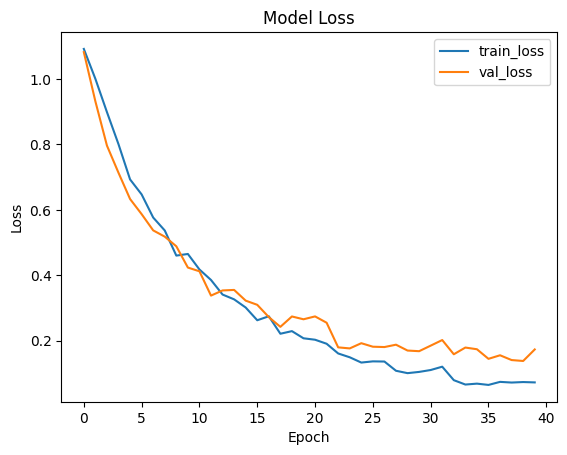

In [22]:
plt.figure()
plt.plot(history['loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

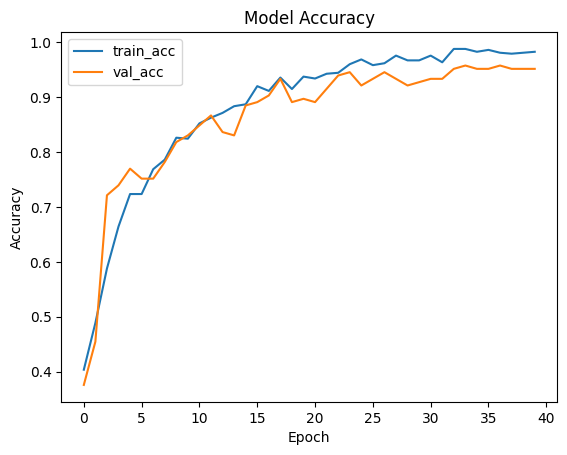

In [23]:
# 2) Accuracy 시각화
plt.figure()
plt.plot(history['accuracy'], label='train_acc')
plt.plot(history['val_accuracy'], label='val_acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [24]:
# 4-3) 검증 데이터에 대한 평가
results_val = model.evaluate(X_val, y_val, batch_size=8, verbose=1)
val_loss, val_acc = results_val[0], results_val[1]
print(f"▶ 검증 데이터 평가 결과  • 손실: {val_loss:.4f}  • 정확도: {val_acc:.4f}")

21/21 [==============================] - 3s 48ms/step - loss: 0.1731 - accuracy: 0.9515
▶ 검증 데이터 평가 결과  • 손실: 0.1731  • 정확도: 0.9515


In [25]:
# ────────────────────────────────────────────────────────────────────────────────
# 추가) 4-4) 테스트 데이터에 대한 평가
results_test = model.evaluate(X_test, y_test, batch_size=8, verbose=1)
test_loss, test_acc = results_test[0], results_test[1]
print(f"▶ 테스트 데이터 평가 결과  • 손실: {test_loss:.4f}  • 정확도: {test_acc:.4f}")

11/11 [==============================] - 2s 141ms/step - loss: 0.1237 - accuracy: 0.9518
▶ 테스트 데이터 평가 결과  • 손실: 0.1237  • 정확도: 0.9518


In [26]:
from sklearn.metrics import confusion_matrix

In [27]:
# 1) 모델에 대한 예측 수행
y_pred_probs = model.predict(X_test)
y_pred_int = np.argmax(y_pred_probs, axis=1)
y_true_int = y_test_int  # 정수 라벨 (원-핫 인코딩 전의 y_test_int)

3/3 [==============================] - 16s 3s/step


In [28]:
# 2) 혼동 행렬 계산 및 출력
cm = confusion_matrix(y_true_int, y_pred_int)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[24  1  0]
 [ 0 24  1]
 [ 1  1 31]]


In [29]:
# 3) 클래스별 정확도 계산
#    - class_counts: 각 클래스의 실제 샘플 수 (혼동 행렬의 각 행 합)
#    - correct_counts: 대각선 값 (맞게 예측된 샘플 수)
class_counts   = cm.sum(axis=1)
correct_counts = np.diag(cm)
class_accuracy = correct_counts / class_counts

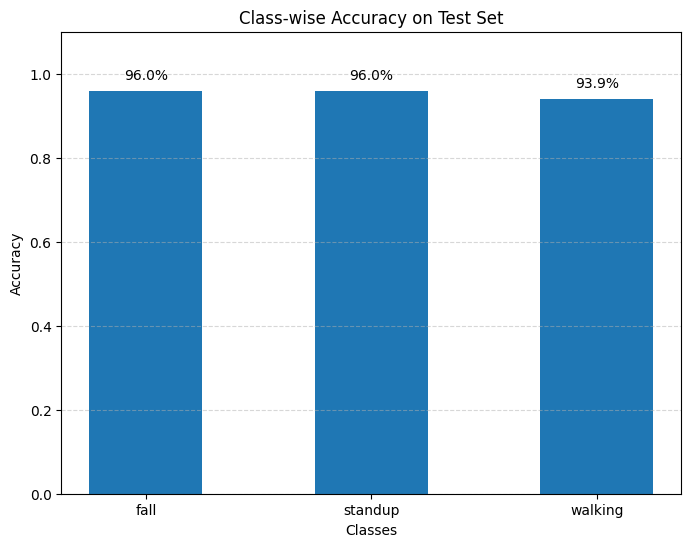

In [30]:
# 4) 클래스 이름 설정
if 'le' in globals():
    class_names = le.classes_
else:
    class_names = [f"Class {i}" for i in range(len(class_accuracy))]

# 5) 막대 그래프 그리기 (너비 조절, 퍼센트 표시)
plt.figure(figsize=(8, 6))
bar_width = 0.5  # 기본 0.8보다 좁게 설정
bars = plt.bar(class_names, class_accuracy, width=bar_width)

# 축 및 타이틀
plt.xlabel("Classes")
plt.ylabel("Accuracy")
plt.title("Class-wise Accuracy on Test Set")
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# 6) 각 막대 위에 퍼센트 레이블 추가
for bar, acc in zip(bars, class_accuracy):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x 위치: 막대 중앙
        height + 0.02,                       # y 위치: 막대 꼭대기 위
        f"{acc * 100:.1f}%",                 # 레이블 텍스트
        ha='center', va='bottom'
    )

plt.show()